# Investigating adjusted p-values from 0ppm vs 625ppm eQTL analysis

__Author:__ Bryan Quach  
__Date:__ May 2, 2017

### Estimated Analysis Time: <1 days

## Objective

There are multiple objectives of this analysis. The main goal is to apply multiple testing correction to the initial results of the eQTL analyses (unadjusted p-values). Following the multiple testing correction, we will address the following questions:

* What is the q-value distribution of our results?
* How many gene-marker pairs produced a significant association?
* How many statistically significant eQTL-containing genes (eGenes) are observed?
* Which gene and marker comparisons produced the most significant hits?
* Which genes tested are eGenes?

## Software required

* [dplyr (R package)](https://cran.r-project.org/web/packages/dplyr/index.html)
* [qvalue (R package)](https://www.bioconductor.org/packages/release/bioc/html/qvalue.html)
* [GenomicRanges (R package)](https://bioconductor.org/packages/release/bioc/html/GenomicRanges.html)

## The Data

The data that we work with are results output from running a modified version of Daniel Oreper's eQTL analysis software. This software produces an R data file containing the environment in which the analysis was run, which includes a matrix of p-values with rows and columns corresponding to genes and markers respectively. In this analysis, we will look at results for the eQTL analyses in lung, liver, and kidney. The phenotype was the fold change of normalized expression (TPM) between 625ppm and 0ppm BD treated CC mice.

## Global multiple testing correction

We apply [FDR correction](https://en.wikipedia.org/wiki/False_discovery_rate) to the p-values from all association tests. The resulting q-values will be used for assessing significance of all gene-marker pairs at a specified threshold. To aid in data analysis, we will convert our matrices of p-values into a data frame with `NA` values removed.

In [1]:
library(dplyr)
library(qvalue)
library(GenomicRanges)

# Function for retrieving non-NA values from matrix
#
# Args:
#   haystack - matrix to search through
#
# Returns a dataframe of the p-values with gene and marker names listed
reshape.results <- function(haystack){
    hits <- which(!is.na(haystack), arr.ind=T)
    rnames <- rownames(haystack)[hits[,1]]
    cnames <- colnames(haystack)[hits[,2]]    
    pvals <- sapply(1:nrow(hits), function(i){haystack[hits[i,1], hits[i,2]]})
    results <- data.frame(gene=rnames, marker=cnames, pval=as.numeric(pvals))
    results <- results[order(results$gene),]
    return(results)
}

#Get p-value matrices for each tissue
tmp.env <- new.env()
load("data/0ppm_vs_625ppm_lung.Rdata", envir=tmp.env)
matrix.lung <- get("out.mat", tmp.env)
load("data/0ppm_vs_625ppm_liver.Rdata", envir=tmp.env)
matrix.liver <- get("out.mat", tmp.env)
load("data/0ppm_vs_625ppm_kidney.Rdata", envir=tmp.env)
matrix.kidney <- get("out.mat", tmp.env)
rm(tmp.env)

#Reshape
pvals.lung <- reshape.results(matrix.lung)
pvals.liver <- reshape.results(matrix.liver)
pvals.kidney <- reshape.results(matrix.kidney)

#Apply FDR correction
qvals.lung <- qvalue(pvals.lung$pval, fdr.level=0.1) 
qvals.liver <- qvalue(pvals.liver$pval, fdr.level=0.1)
qvals.kidney <- qvalue(pvals.kidney$pval, fdr.level=0.1)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, cbind, colMeans, colnames,
    colSums, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, len

## Identifying significant eGenes

For downstream analyses that focus only on the gene-level results, we will assign a representative p-value for each gene. A common approach to do this is to use the smallest p-value for a gene across tests as a test statistic. A permutation test is then applied where the gene expression values are permuted, and a p-value is derived from this permutation test procedure. Because this is computationally too expensive given our current resources, we will instead apply [Bonferroni correction](https://en.wikipedia.org/wiki/Bonferroni_correction) to the p-values from each marker test with a gene. In this approach we tabulate the number of tests performed for each gene then multiply each p-value by that number. We will use the smallest Bonferroni corrected p-value as the representative p-value for a gene. We will then account for multiple comparisons across genes by appyling FDR correction.

In [2]:
#Apply Bonferroni correction
matrix.adj.lung <- matrix.lung * apply(matrix.lung,1,function(x){length(which(!is.na(x)))})
matrix.adj.liver <- matrix.liver * apply(matrix.liver,1,function(x){length(which(!is.na(x)))})
matrix.adj.kidney <- matrix.kidney * apply(matrix.kidney,1,function(x){length(which(!is.na(x)))})

#Apply value ceiling of 1 to p-values
matrix.adj.lung <- apply(matrix.adj.lung, 2, function(x){ifelse(x>1,1,x)})
matrix.adj.liver <- apply(matrix.adj.liver, 2, function(x){ifelse(x>1,1,x)})
matrix.adj.kidney <- apply(matrix.adj.kidney, 2, function(x){ifelse(x>1,1,x)})

#Assign representative p-value to each gene
gene.pval.lung <- apply(matrix.adj.lung, 1, min, na.rm=T)
if(length(which(gene.pval.lung==Inf))>0){ gene.pval.lung <- gene.pval.lung[-1*which(gene.pval.lung==Inf)] }
gene.pval.liver <- apply(matrix.adj.liver, 1, min, na.rm=T)
if(length(which(gene.pval.liver==Inf))>0){ gene.pval.liver <- gene.pval.liver[-1*which(gene.pval.liver==Inf)] }
gene.pval.kidney <- apply(matrix.adj.kidney, 1, min, na.rm=T)
if(length(which(gene.pval.kidney==Inf))>0){ gene.pval.kidney <- gene.pval.kidney[-1*which(gene.pval.kidney==Inf)] }

#Apply FDR correction
gene.qval.lung <- qvalue(p=gene.pval.lung, fdr.level=0.1)
gene.qval.liver <- qvalue(p=gene.pval.liver, fdr.level=0.1)
gene.qval.kidney <- qvalue(p=gene.pval.kidney, fdr.level=0.1)

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to min; returning Inf”Warning message in FUN(newX[, i], ...):
“no non-missing arguments to min; returning Inf”Warning message in FUN(newX[, i], ...):
“no non-missing arguments to min; returning Inf”Warning message in FUN(newX[, i], ...):
“no non-missing arguments to min; returning Inf”Warning message in FUN(newX[, i], ...):
“no non-missing arguments to min; returning Inf”Warning message in FUN(newX[, i], ...):
“no non-missing arguments to min; returning Inf”

## Plotting statistics

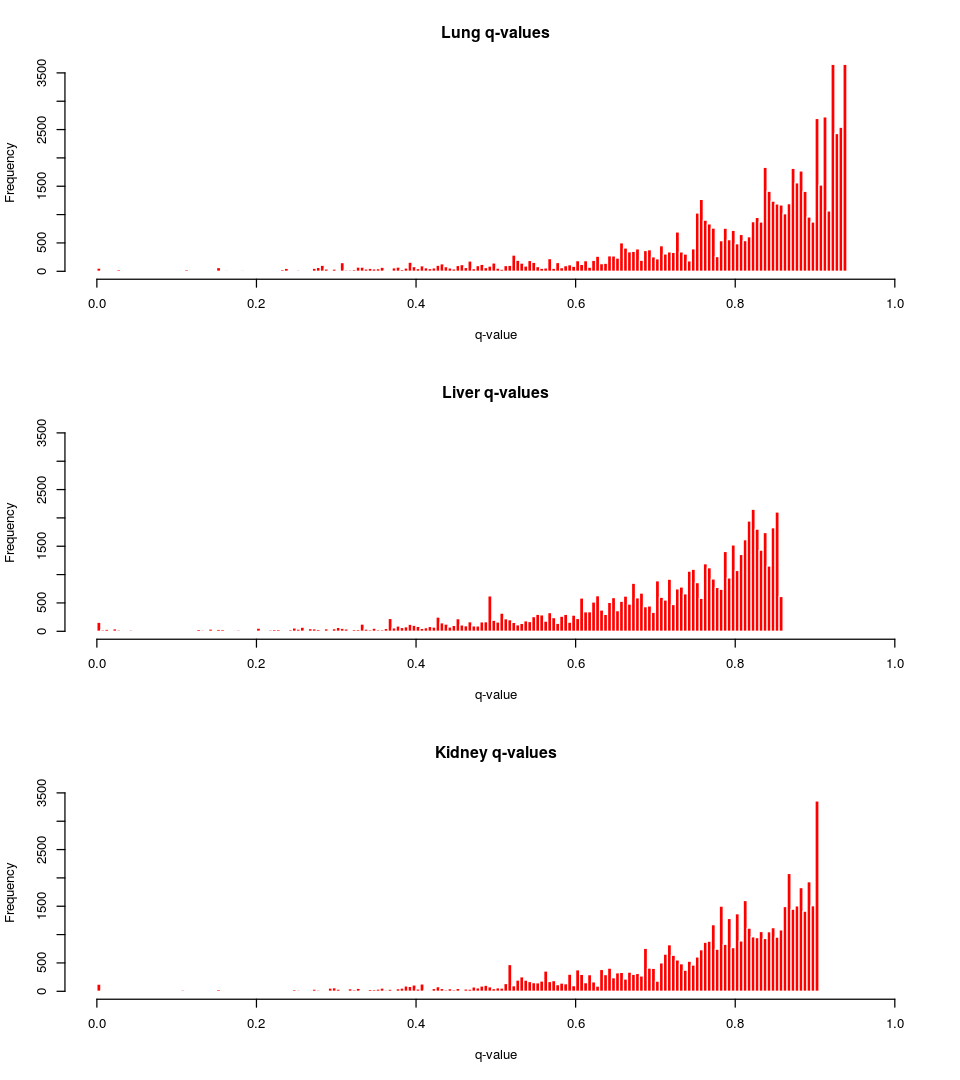

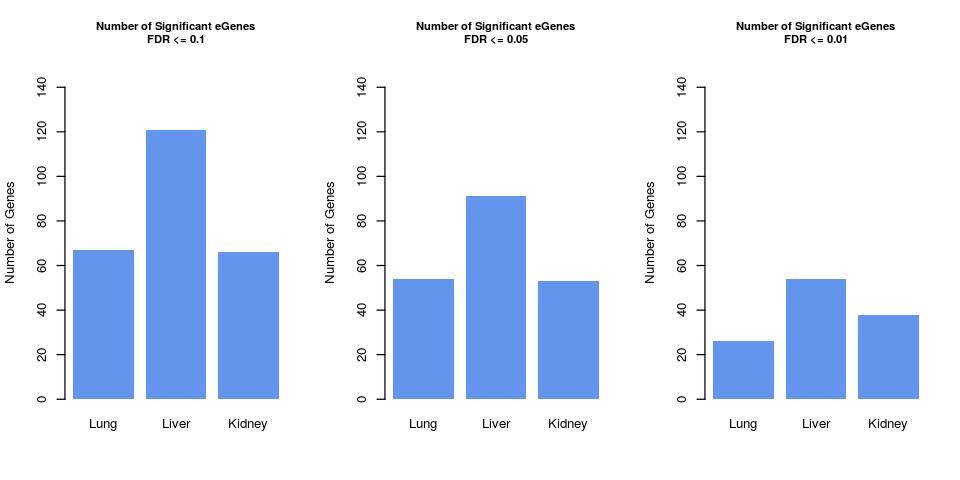

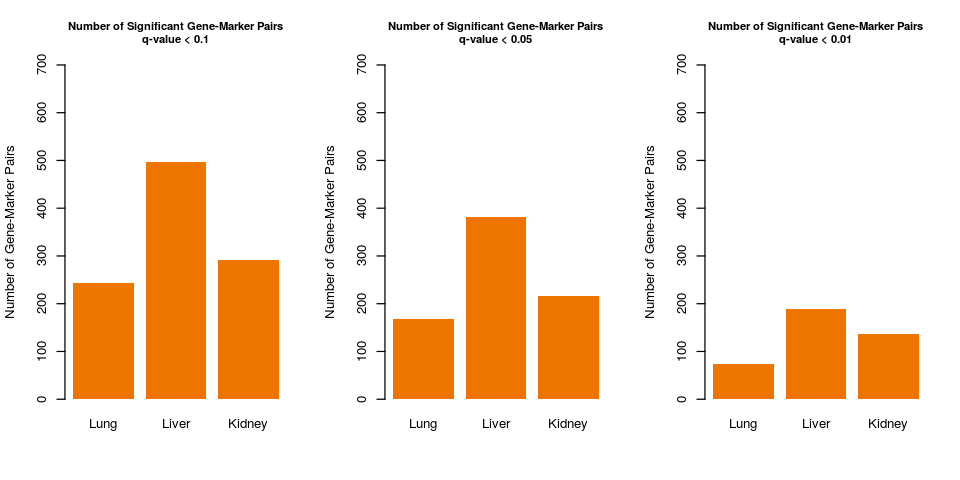

In [3]:
library(repr)

#P-value distributions
options(repr.plot.width=8, repr.plot.height=9)
par(mfrow=c(3,1))
hist(as.numeric(qvals.lung$qvalues), breaks=200, freq=T, ylim=c(0,3500), xlim=c(0,1),
     col="red", border="white",
     main="Lung q-values",
     ylab="Frequency",
     xlab="q-value")
hist(as.numeric(qvals.liver$qvalues), breaks=200, freq=T, ylim=c(0,3500), xlim=c(0,1),
     col="red", border="white",
     main="Liver q-values",
     ylab="Frequency", 
     xlab="q-value")
hist(as.numeric(qvals.kidney$qvalues), breaks=200, freq=T, ylim=c(0,3500), xlim=c(0,1),
     col="red", border="white",
     main="Kidney q-values",
     ylab="Frequency", 
     xlab="q-value")


#Calculate significant eGenes and gene marker pairs
for(cutoff in c(0.1,0.05,0.01)){
    num.egenes.lung <- length(which(gene.qval.lung$qvalues<cutoff))
    num.egenes.liver <- length(which(gene.qval.liver$qvalues<cutoff))
    num.egenes.kidney <- length(which(gene.qval.kidney$qvalues<cutoff))
    assign(x=paste0("num.egenes.",cutoff),value=c(num.egenes.lung, num.egenes.liver, num.egenes.kidney))

    num.sig.lung <- length(which(qvals.lung$qvalues<cutoff))
    num.sig.liver <- length(which(qvals.liver$qvalues<cutoff))
    num.sig.kidney <- length(which(qvals.kidney$qvalues<cutoff))
    assign(x=paste0("num.sig.",cutoff),value=c(num.sig.lung, num.sig.liver, num.sig.kidney))
}

#Significant eGenes
options(repr.plot.width=8, repr.plot.height=4)
par(mfrow=c(1,3))
barplot(height=num.egenes.0.1, beside=T, ylab="Number of Genes", ylim=c(0,150),
        border=NA, col="cornflowerblue",
        names.arg=c("Lung","Liver","Kidney"), 
        main="Number of Significant eGenes\nFDR <= 0.1",
        cex.main=0.85)
barplot(height=num.egenes.0.05, beside=T, ylab="Number of Genes", ylim=c(0,150),
        border=NA, col="cornflowerblue",
        names.arg=c("Lung","Liver","Kidney"), 
        main="Number of Significant eGenes\nFDR <= 0.05",
        cex.main=0.85)
barplot(height=num.egenes.0.01, beside=T, ylab="Number of Genes", ylim=c(0,150),
        border=NA, col="cornflowerblue",
        names.arg=c("Lung","Liver","Kidney"), 
        main="Number of Significant eGenes\nFDR <= 0.01",
        cex.main=0.85)


#Significant gene marker paris
par(mfrow=c(1,3))
barplot(height=num.sig.0.1, beside=T, ylab="Number of Gene-Marker Pairs", ylim=c(0,700),
        border=NA, col="darkorange2",
        names.arg=c("Lung","Liver","Kidney"), 
        main="Number of Significant Gene-Marker Pairs\nq-value < 0.1",
        cex.main=0.85)
barplot(height=num.sig.0.05, beside=T, ylab="Number of Gene-Marker Pairs", ylim=c(0,700),
        border=NA, col="darkorange2",
        names.arg=c("Lung","Liver","Kidney"), 
        main="Number of Significant Gene-Marker Pairs\nq-value < 0.05",
        cex.main=0.85)
barplot(height=num.sig.0.01, beside=T, ylab="Number of Gene-Marker Pairs", ylim=c(0,700),
        border=NA, col="darkorange2",
        names.arg=c("Lung","Liver","Kidney"), 
        main="Number of Significant Gene-Marker Pairs\nq-value < 0.01",
        cex.main=0.85)

## Retrieving most significant associations

For each tissue, we retrieve the 100 gene-marker pairs that produced the most significant q-values and list them below. Notably, not all the records listed have q-values that would pass typical thresholds.

In [4]:
#Load marker coordinates and gene expression data
tmp.env <- new.env()
load("data/0ppm_vs_625ppm_lung.Rdata", envir=tmp.env)
tmp.data <- get("inp", tmp.env)
rna.levels.lung <- tmp.data$exp.mat
marker.map <- tmp.data$marker.map
load("data/0ppm_vs_625ppm_liver.Rdata", envir=tmp.env)
tmp.data <- get("inp", tmp.env)
rna.levels.liver <- tmp.data$exp.mat
load("data/0ppm_vs_625ppm_kidney.Rdata", envir=tmp.env)
tmp.data <- get("inp", tmp.env)
rna.levels.kidney <- tmp.data$exp.mat
rm(tmp.env, tmp.data)

#Make data frame of sorted results and subset
lung.list <- cbind(pvals.lung, qval=qvals.lung$qvalues)
lung.list <- lung.list[order(lung.list$qval),]
liver.list <- cbind(pvals.liver, qval=qvals.liver$qvalues)
liver.list <- liver.list[order(liver.list$qval),]
kidney.list <- cbind(pvals.kidney, qval=qvals.kidney$qvalues)
kidney.list <- kidney.list[order(kidney.list$qval),]
top.lung.list <- lung.list[1:100,]
top.liver.list <- liver.list[1:100,]
top.kidney.list <- kidney.list[1:100,]

#Get genomic coordinates for top markers
get.location <- function(marker, marker.map){
    boundary.markers <- unlist(strsplit(x=marker, split=".", fixed=T))
    m.index1 <- which(marker.map$marker==boundary.markers[1])
    m.index2 <- which(marker.map$marker==boundary.markers[2])
    if(length(m.index1)!=1 | length(m.index2)!=1){
        error_msg <- paste0("Error: Marker not found in marker map: ", marker)
        stop(error_msg)
    }
    #Get marker region
    m1 <- marker.map[m.index1,]
    m2 <- marker.map[m.index2,]
    if(m1$chromosome!=m2$chromosome){stop("Error: Markers merged across chromosomes!")}
    m.region <- c(m1$chromosome, m1$position, m2$position)
    return(m.region)
}
top.lung.list <- cbind(top.lung.list, t(sapply(as.character(top.lung.list$marker), get.location, marker.map=marker.map)))[,c(1,2,5,6,7,3,4)]
top.liver.list <- cbind(top.liver.list, t(sapply(as.character(top.liver.list$marker), get.location, marker.map=marker.map)))[,c(1,2,5,6,7,3,4)]
top.kidney.list <- cbind(top.kidney.list, t(sapply(as.character(top.kidney.list$marker), get.location, marker.map=marker.map)))[,c(1,2,5,6,7,3,4)]
colnames(top.lung.list)[3:5] <- c("chr", "start", "end")
colnames(top.liver.list)[3:5] <- c("chr", "start", "end")
colnames(top.kidney.list)[3:5] <- c("chr", "start", "end")

#Get gene expression statistics
gene.calc <- function(gene, expression){
    abundance <- expression[,colnames(expression)==gene]
    return(c(mean(abundance), sd(abundance), range(abundance)))
}
gene.stats.lung <- t(sapply(top.lung.list$gene, gene.calc, expression=rna.levels.lung))
gene.stats.liver <- t(sapply(top.liver.list$gene, gene.calc, expression=rna.levels.liver))
gene.stats.kidney <- t(sapply(top.kidney.list$gene, gene.calc, expression=rna.levels.kidney))
top.lung.list <- cbind(top.lung.list, gene.stats.lung)
top.liver.list <- cbind(top.liver.list, gene.stats.liver)
top.kidney.list <- cbind(top.kidney.list, gene.stats.kidney)
colnames(top.lung.list)[8:11] <- c("mean.expression", "sd.expression", "min.expression","max.exprresion")
colnames(top.liver.list)[8:11] <- c("mean.expression", "sd.expression", "min.expression","max.exprresion")
colnames(top.kidney.list)[8:11] <- c("mean.expression", "sd.expression", "min.expression","max.exprresion")

#Display tables
cat("Lung\n")
top.lung.list
cat("Liver\n")
top.liver.list
cat("Kidney\n")
top.kidney.list

#Write tables to file
write.table(x=top.lung.list, file="results/lung_top100_hits_adjusted_pvals.txt", 
            quote=F, row.names=F, col.names=T, sep="\t")
write.table(x=top.liver.list, file="results/liver_top100_hits_adjusted_pvals.txt", 
            quote=F, row.names=F, col.names=T, sep="\t")
write.table(x=top.kidney.list, file="results/kidney_top100_hits_adjusted_pvals.txt", 
            quote=F, row.names=F, col.names=T, sep="\t")


Lung


gene          marker                         chr   start     end      
24894 Klk1b3        JAX00150542.UNC12706160        chr7  49202345  50664468 
24976 Klk1b3        UNC12706670.JAX00637356        chr7  50701898  52011328 
25107 Klk1b3        UNC12722783.UNC12729352        chr7  52019456  52620008 
57642 Cyp4f13       UNC27775382.JAX00075089        chr17 31903252  32316401 
65806 Rhox8         UNC30750883.UNC30753391        chrX  35440856  35862204 
32755 Olfr922       UNC16177202.UNC16189957        chr9  37440457  38326154 
32773 Olfr922       UNC16190786.JAX00691103        chr9  38399972  40032862 
65819 Rhox8         JAX00178139.JAX00710854        chrX  35887961  40064572 
51898 Ly6f          UNC25896223.UNC25904367        chr15 74595504  75277140 
32803 Zfp202        UNC16215275.JAX00170415        chr9  40218052  40967574 
32778 Zfp202        UNC16190786.JAX00691103        chr9  38399972  40032862 
32790 Zfp202        JAX00691111.UNC16215188        chr9  40069080  40211294 
18637 Fam20c        UNC10291007.UNC10306321        chr5  139780797 140933260
12612 Kti12         UNC7932936.UNC7947729          chr4  107007905 108092055
31378 Calb2         UNC15475106.UNC15477711        chr8  111697739 111898243
31393 Calb2         UNC15478095.UNC15484083        chr8  111926923 112443662
18629 C130050O18Rik UNC10291007.UNC10306321        chr5  139780797 140933260
1267  Scarna6       JAX00258020.UNC1103435         chr1  88609381  90627755 
18653 Prkar1b       UNC10291007.UNC10306321        chr5  139780797 140933260
30971 Prss54        UNC15261596.UNC15289340        chr8  95411111  97327534 
31045 Prss54        UNC15290728.UNC15290993        chr8  97447160  97462618 
31008 Prss54        UNC15290259.UNC15290706        chr8  97402286  97445918 
15546 A930003O13Rik UNC8769425.UNC8791233          chr5  21016194  22478235 
40789 Nlrp1c-ps     UNC19872847.UNC19880458        chr11 69818557  70591519 
40866 Nlrp1c-ps     JAX00198578.UNC19882781        chr11 70599251  70827760 
40955 Nlrp1c-ps     UNC19894275.JAX00315100        chr11 71640441  71760535 
15665 Shh           UNC8864558.UNC8865208          chr5  28559982  28602718 
16305 C030018K13Rik UNC9340181.UNC9365328          chr5  64851136  66767906 
40923 Nlrp1c-ps     JAX00028823.UNC19893865        chr11 70853525  71603337 
40981 Nlrp1c-ps     UNC19896849.UNC19898574        chr11 71792912  71952410 
⋮     ⋮             ⋮                              ⋮     ⋮         ⋮        
45586 Rab15         UNC21431183.UNC21450718        chr12 77606486  79190107 
45560 Rab15         UNC21417007.UNC21430862        chr12 76431588  77583962 
55498 Olfr193       UNC26903376.JAX00422198        chr16 58111252  58258314 
31119 Prss54        UNC15291061.UNC15298896        chr8  97467032  98222743 
31165 Prss54        JAX00677426.UNC15335709        chr8  98392837  100886072
6278  Blvra         UNC3915237.UNC3927323          chr2  125946359 127064792
567   Stat4         JAX00003651.UNC662361          chr1  51892854  51916010 
554   Stat4         UNC652639.UNC655907            chr1  51237603  51487121 
27697 Zfp764        UNC13807161.UNC13807864        chr7  133997968 134107195
31145 Prss54        UNC15298908.UNC15299899        chr8  98224443  98355043 
560   Stat4         JAX00250410.UNC661934          chr1  51503806  51887395 
6043  1700054M17Rik UNC3817290.UNC3817950          chr2  117184728 117220722
36653 Chchd10       JAX00019727.JAX00019795        chr10 75561224  76478312 
25882 Mir6416       UNC070516320.UNC13020010       chr7  71538916  73098968 
65286 Ssxb10        UNC30618429.JAX00708748        chrX  6897090   6992614  
45169 Lrrc72        UNC20880016.UNC20898235        chr12 35674697  36899209 
49839 Osgep         UNC23990985.backupUNC140394528 chr14 50935892  51641939 
550   Stat4         JAX00249717.UNC651262          chr1  46982881  51147081 
45181 Lrrc72        UNC20898693.UNC20907554        chr12 36922142  37548043 
45191 Lrrc72        JAX00330700.UNC_rs48206748     chr12 37624976  37893079 
49

Liver


gene      marker                   chr   start     end       pval        
31818 Cs        JAX00302230.UNC18963675  chr10 127068725 127267133 5.291062e-45
31886 Cs        UNC18963682.JAX00302406  chr10 127267455 127919711 5.619315e-45
31762 Cs        UNC18954707.UNC18961845  chr10 126429359 127050365 8.645751e-45
31522 Tbc1d15   UNC18783466.UNC18790786  chr10 115263404 115714809 2.532798e-25
31479 Tbc1d15   UNC18771926.UNC18777516  chr10 114498531 114868719 3.229128e-25
41968 Gch1      UNC23970682.UNC23981059  chr14 48797144  49793554  1.095539e-23
31906 Mettl7b   UNC18963682.JAX00302406  chr10 127267455 127919711 6.805896e-23
31962 Mettl7b   UNC18970636.UNC101328991 chr10 127924035 128389507 6.350865e-23
32009 Mettl7b   JAX00302462.JAX00302527  chr10 128394706 128919120 6.628266e-23
32038 Mettl7b   UNC18980143.UNC18983661  chr10 128988719 129385947 6.079947e-23
15526 Tmem184a  UNC10291007.UNC10306321  chr5  139780797 140933260 9.302190e-18
4217  Pbx3      UNC2862710.UNC2910745    chr2  34844499  40109809  4.902009e-17
4183  Pbx3      UNC2845901.UNC2862042    chr2  33101544  34801962  6.090238e-17
910   Farsb     UNC995424.UNC1036770     chr1  78615218  81671764  8.354085e-16
31682 Arhgef25  UNC18933797.JAX00023513  chr10 125160881 126375436 1.768029e-15
896   Farsb     JAX00256220.JAX00256288  chr1  78069656  78315068  1.812400e-15
900   Farsb     UNC991403.JAX00256367    chr1  78333109  78561590  1.672808e-15
31718 Arhgef25  UNC18954024.UNC18954348  chr10 126377348 126398272 2.210550e-15
31757 Arhgef25  UNC18954707.UNC18961845  chr10 126429359 127050365 2.348321e-15
31692 Inhbe     UNC18933797.JAX00023513  chr10 125160881 126375436 2.930807e-15
31728 Inhbe     UNC18954024.UNC18954348  chr10 126377348 126398272 3.055315e-15
31772 Inhbe     UNC18954707.UNC18961845  chr10 126429359 127050365 3.196605e-15
31830 Inhbe     JAX00302230.UNC18963675  chr10 127068725 127267133 3.168774e-15
31898 Inhbe     UNC18963682.JAX00302406  chr10 127267455 127919711 3.157073e-15
5052  Myef2     UNC3901678.UNC3903867    chr2  124835230 125004135 3.293513e-15
5065  Myef2     UNC3904397.UNC3914380    chr2  125037393 125827708 3.242066e-15
5079  Myef2     JAX00502398.UNC3914924   chr2  125867453 125884099 3.242065e-15
5102  Myef2     UNC3915237.UNC3927323    chr2  125946359 127064792 3.641007e-15
31812 Arhgef25  JAX00302230.UNC18963675  chr10 127068725 127267133 3.961015e-15
31878 Arhgef25  UNC18963682.JAX00302406  chr10 127267455 127919711 3.882258e-15
⋮     ⋮         ⋮                        ⋮     ⋮         ⋮         ⋮           
48335 Gm17801   UNC27694572.UNC27714988  chr17 25154006  26777986  5.360926e-08
5685  Rad21l    JAX00101596.UNC4230076   chr2  150484638 150824208 8.063278e-08
5702  Rad21l    UNC4230433.JAX00101624   chr2  150844593 150862920 9.071241e-08
31568 Dyrk2     JAX00300302.UNC18847088  chr10 119161171 119604795 9.337288e-08
5719  Rad21l    UNC4230833.UNC4230865    chr2  150906310 150933303 9.985998e-08
5738  Rad21l    UNC4230993.UNC020228210  chr2  150975320 151200992 9.980904e-08
5766  Rad21l    UNC4231314.UNC4240403    chr2  151219679 152022486 9.730967e-08
5793  Rad21l    UNC4240934.UNC4241542    chr2  152114896 152182914 9.896703e-08
5819  Rad21l    UNC4242301.UNC4242810    chr2  152249465 152299446 9.857001e-08
5845  Rad21l    JAX00101732.UNC4244689   chr2  152314288 152468096 9.839031e-08
15544 Tmem184a  UNC10306786.UNC10306786  chr5  140960924 140960924 1.036556e-07
24018 Rprl3     JAX00659261.UNC14053566  chr8  3235539   3427000   1.068434e-07
42551 Chrna2    UNC24144884.UNC24154070  chr14 66772738  67405250  1.281663e-07
23994 Rprl3     JAX00659253.JAX00659253  chr8  3211459   3211459   1.287353e-07
31269 Mir3058   UNC18471910.UNC18474836  chr10 93964372  94207553  1.318558e-07
31285 Mir3058   UNC18475040.UNC18480813  chr10 94227755  94633926  1.486880e-07
31299 Mir3058   UNC18481354.UNC18483765  chr10 94672807  94825789  1.536419e-07
48250 Gm17801   UNC170299097.UNC27694074 chr17 23782631  25086028  2.282612e-07
49091 

Kidney


gene          marker                         chr   start     end      
20606 Scgb1b29      UNC12581313.JAX00149918        chr7  31886494  33121652 
20617 Scgb1b29      UNC12586775.UNC12586775        chr7  33149026  33149026 
20619 Scgb1b29      UNC070069629.UNC12586965       chr7  33362735  34082037 
20623 Scgb1b29      UNC070070026.UNC070070026      chr7  34170589  34170589 
9363  Cfap206       UNC7051473.JAX00548318         chr4  35418782  35769492 
9356  Cfap206       UNC7048955.UNC7051291          chr4  35160432  35386725 
42337 Lgals3        UNC23970682.UNC23981059        chr14 48797144  49793554 
6552  Gm14288       UNC4549947.UNC4556034          chr2  173880924 174374593
6564  Gm14288       UNC4556542.UNC4558476          chr2  174406645 174549940
6575  Gm14288       JAX00512370.UNC4561324         chr2  174571924 177297145
4432  Gm13580       UNC3167310.UNC3170841          chr2  60858409  61129654 
42332 3632451O06Rik UNC23970682.UNC23981059        chr14 48797144  49793554 
42341 3632451O06Rik UNC23981303.UNC23982070        chr14 49830755  49904420 
42343 3632451O06Rik UNC140178161.UNC23990240       chr14 50027179  50800729 
9347  Cfap206       JAX00548233.UNC040493917       chr4  34916372  35116166 
42361 3632451O06Rik UNC23990985.backupUNC140394528 chr14 50935892  51641939 
15046 Zbed5         UNC10173561.UNC10177662        chr5  131157768 131386889
48553 Hcfc1r1       UNC170299097.UNC27694074       chr17 23782631  25086028 
26329 Slc9a5        UNC15422872.UNC15460754        chr8  106893004 110484145
42334 Dlgap5        UNC23970682.UNC23981059        chr14 48797144  49793554 
26256 Cmtm3         UNC15417874.UNC15422538        chr8  106499195 106863747
26292 Cmtm3         UNC15422872.UNC15460754        chr8  106893004 110484145
26235 Cmtm3         UNC15416961.JAX00679081        chr8  106429699 106464668
26222 Cmtm3         UNC15401027.JAX00679070        chr8  105224029 106423866
44025 Lynx1         UNC25871106.UNC25886541        chr15 72712691  73893779 
44050 Lynx1         UNC25886803.UNC25888076        chr15 73905944  73987481 
44110 Lynx1         UNC25896223.UNC25904367        chr15 74595504  75277140 
49621 E130008D07Rik UNC27900544.UNC27900544        chr17 44170714  44170714 
44076 Lynx1         UNC25888851.UNC25895704        chr15 74042551  74542039 
26270 4930506A18Rik UNC15422872.UNC15460754        chr8  106893004 110484145
⋮     ⋮             ⋮                              ⋮     ⋮         ⋮        
54657 Gm8978        UNC30216687.UNC30216687        chr19 33056792  33056792 
40178 Hist1h4a      UNC22267867.UNC22314902        chr13 24047749  27411431 
49607 E130008D07Rik UNC27853628.UNC27900428        chr17 40739102  44164206 
40930 Slc6a19os     UNC22845435.UNC22853947        chr13 72783714  73355323 
15962 N4bp2l1       UNC10451000.UNC10451000        chr5  151364972 151364972
15967 N4bp2l1       UNC10451055.JAX00137288        chr5  151368031 152230960
15972 N4bp2l1       UNC10462381.UNC10462381        chr5  152279079 152279079
24817 Mir8108       UNC14334524.UNC14334524        chr8  26092501  26092501 
24832 Mir8108       UNC14334951.JAX00159821        chr8  26133140  26264908 
24847 Mir8108       UNC14337122.UNC14337122        chr8  26293182  26293182 
24863 Mir8108       UNC14337730.UNC14337730        chr8  26336577  26336577 
24879 Mir8108       UNC14338157.UNC14338157        chr8  26362942  26362942 
24895 Mir8108       JAX00663607.JAX00663607        chr8  26363384  26363384 
24911 Mir8108       UNC14338945.UNC14340808        chr8  26415103  26520819 
24803 Mir8108       JAX00663556.UNC14333584        chr8  25991615  26038735 
24727 Mir8108       UNC14323091.JAX00663443        chr8  25252292  25421450 
24734 Mir8108       UNC14326048.UNC14326048        chr8  25441955  25441955 
24741 Mir8108       UNC14326919.UNC14326919        chr8  25489899  25489899 
24749 Mir8108       UNC14327672.JAX00159775        chr8  25532577  25635600 
24758 Mir8108       UNC14329978.UNC080083433       chr8  25666280  25768479 
24

## Retrieving significant eGenes

For each tissue, we retrieve significant eGenes (FDR <= 0.1) and list them below.

In [5]:
#Load gene coordinates
tmp.env <- new.env()
load("data/0ppm_vs_625ppm_lung.Rdata", envir=tmp.env)
tmp.data <- get("inp", tmp.env)
gene.map <- tmp.data$cis.map #GenomicRanges object
rm(tmp.env, tmp.data)

#Make data frame of sorted results and subset
lung.gene.list <- data.frame(gene.pval.lung, qval=gene.qval.lung$qvalues)
lung.gene.list <- lung.gene.list[order(lung.gene.list$qval),]
liver.gene.list <- data.frame(gene.pval.liver, qval=gene.qval.liver$qvalues)
liver.gene.list <- liver.gene.list[order(liver.gene.list$qval),]
kidney.gene.list <- data.frame(gene.pval.kidney, qval=gene.qval.kidney$qvalues)
kidney.gene.list <- kidney.gene.list[order(kidney.gene.list$qval),]
colnames(lung.gene.list) <- c("pval","qval")
colnames(liver.gene.list) <- c("pval","qval")
colnames(kidney.gene.list) <- c("pval","qval")
top.genes.lung <- lung.gene.list[which(lung.gene.list$qval<=0.1),]
top.genes.liver <- liver.gene.list[which(liver.gene.list$qval<=0.1),]
top.genes.kidney <- kidney.gene.list[which(kidney.gene.list$qval<=0.1),]

#Get gene locations
locations.lung <- sapply(rownames(top.genes.lung), function(x, map){as.character(map[which(map$gene==x),])}, map=gene.map)
locations.liver <- sapply(rownames(top.genes.liver), function(x, map){as.character(map[which(map$gene==x),])}, map=gene.map)
locations.kidney <- sapply(rownames(top.genes.kidney), function(x, map){as.character(map[which(map$gene==x),])}, map=gene.map)
top.genes.lung <- cbind(top.genes.lung, locations.lung)
top.genes.liver <- cbind(top.genes.liver, locations.liver)
top.genes.kidney <- cbind(top.genes.kidney, locations.kidney)
colnames(top.genes.lung)[3] <- "coordinate"
colnames(top.genes.liver)[3] <- "coordinate"
colnames(top.genes.kidney)[3] <- "coordinate"

#Get gene expression statistics
gene.stats.lung <- t(sapply(rownames(top.genes.lung), gene.calc, expression=rna.levels.lung))
gene.stats.liver <- t(sapply(rownames(top.genes.liver), gene.calc, expression=rna.levels.liver))
gene.stats.kidney <- t(sapply(rownames(top.genes.kidney), gene.calc, expression=rna.levels.kidney))
top.genes.lung <- cbind(top.genes.lung, gene.stats.lung)
top.genes.liver <- cbind(top.genes.liver, gene.stats.liver)
top.genes.kidney <- cbind(top.genes.kidney, gene.stats.kidney)
colnames(top.genes.lung)[4:7] <- c("mean.expression", "sd.expression", "min.expression","max.exprresion")
colnames(top.genes.liver)[4:7] <- c("mean.expression", "sd.expression", "min.expression","max.exprresion")
colnames(top.genes.kidney)[4:7] <- c("mean.expression", "sd.expression", "min.expression","max.exprresion")


#Display tables
cat("Lung\n")
top.genes.lung
cat("Liver\n")
top.genes.liver
cat("Kidney\n")
top.genes.kidney

#Write tables to file
write.table(x=top.genes.lung, file="results/lung_egenes_0_vs_625.txt", 
            quote=F, row.names=T, col.names=T, sep="\t")
write.table(x=top.genes.liver, file="results/liver_egenes_0_vs_625.txt", 
            quote=F, row.names=T, col.names=T, sep="\t")
write.table(x=top.genes.kidney, file="results/kidney_egenes_0_vs_625.txt", 
            quote=F, row.names=T, col.names=T, sep="\t")


Lung


pval         qval         coordinate              
Klk1b3        4.586212e-17 6.506000e-13 chr7:50453560-52453561  
Cyp4f13       8.930749e-11 6.334580e-07 chr17:32084305-34084306 
Olfr922       5.970976e-10 2.117607e-06 chr9:37622992-39622993  
Rhox8         4.892720e-10 2.117607e-06 chrX:34232120-36232121  
Ly6f          1.481295e-08 3.502274e-05 chr15:74098850-76098851 
Zfp202        1.429820e-08 3.502274e-05 chr9:38999900-40999901  
Fam20c        7.511640e-08 1.522288e-04 chr5:138231034-140231035
Kti12         1.472007e-07 2.610237e-04 chr4:107520461-109520462
Calb2         2.213391e-07 3.488796e-04 chr8:111692105-113692106
Scarna6       3.186032e-07 4.519705e-04 chr1:88681145-90681146  
C130050O18Rik 3.613953e-07 4.660685e-04 chr5:138882340-140882341
A930003O13Rik 6.158658e-07 7.280560e-04 chr5:21252701-23252702  
Prkar1b       6.762514e-07 7.379464e-04 chr5:138606339-140606340
C030018K13Rik 1.600836e-06 1.513964e-03 chr5:63868246-65868247  
Prss54        1.599922e-06 1.513964e-03 chr8:97099506-99099507  
Nlrp1c-ps     1.832569e-06 1.624801e-03 chr11:70098733-72098734 
Osr1          3.536808e-06 2.787398e-03 chr12:8581247-10581248  
Shh           3.397361e-06 2.787398e-03 chr5:27793640-29793641  
Trap1a        5.928573e-06 4.426460e-03 chrX:134868221-136868222
Krtap6-5      6.441557e-06 4.568996e-03 chr16:88048143-90048144 
Stub1         7.395222e-06 4.995648e-03 chr17:24970305-26970306 
Pofut2        8.171302e-06 5.269004e-03 chr10:75722044-77722045 
1700095J12Rik 9.144285e-06 5.640036e-03 chr4:136694432-138694433
Olfr193       1.066547e-05 6.304183e-03 chr16:58110433-60110434 
Zfp608        1.145086e-05 6.497673e-03 chr18:54149833-56149834 
4930525C09Rik 1.321077e-05 7.208001e-03 chr10:96177405-98177406 
1700054M17Rik 2.125544e-05 1.050315e-02 chr2:117130649-119130650
Hist1h1d      2.147127e-05 1.050315e-02 chr13:22646900-24646901 
Rab15         2.126330e-05 1.050315e-02 chr12:76923510-78923511 
Stat4         2.517788e-05 1.190578e-02 chr1:51043991-53043992  
⋮             ⋮            ⋮            ⋮                       
Ush1c         5.273017e-05 0.02004083   chr7:52493859-54493860  
Gm16287       5.612167e-05 0.02041390   chr4:137736569-139736570
Chchd10       7.250025e-05 0.02416245   chr10:74398317-76398318 
Lrrc72        7.020245e-05 0.02416245   chr12:35979984-37979985 
Mir6416       7.324019e-05 0.02416245   chr7:70394984-72394985  
Osgep         6.909726e-05 0.02416245   chr14:50544567-52544568 
Ctla2a        8.981388e-05 0.02831333   chr13:60037985-62037986 
Rgs18         8.972088e-05 0.02831333   chr1:145622550-147622551
Blvra         9.423108e-05 0.02906005   chr2:125896392-127896393
Acss2os       1.107290e-04 0.03272504   chr2:154382665-156382666
Cd40          1.084285e-04 0.03272504   chr2:163881135-165881136
Cpne4         1.179157e-04 0.03400857   chr9:103472117-105472118
Sirt1         1.198667e-04 0.03400857   chr10:61801782-63801783 
Mir684-2      1.266168e-04 0.03454202   chr4:10061243-12061244  
Shc3          1.256471e-04 0.03454202   chr13:50662452-52662453 
Ssxb10        1.523429e-04 0.04077615   chrX:6904549-8904550    
Dnajc4        1.879524e-04 0.04937578   chr19:6066761-8066762   
AI506816      1.940124e-04 0.05004109   chr5:22218484-24218485  
4930401O12Rik 2.330466e-04 0.05834788   chr13:30332954-32332955 
Map1a         2.361646e-04 0.05834788   chr2:120115337-122115338
Nr1i2         2.385575e-04 0.05834788   chr16:37294909-39294910 
Fdx1          2.787787e-04 0.06591258   chr9:50771706-52771707  
Tnn           2.780060e-04 0.06591258   chr1:161083705-163083706
Sorbs1        2.846740e-04 0.06620305   chr19:39588301-41588302 
Gm10228       2.992341e-04 0.06839068   chr16:88041716-90041717 
Pgr           3.037229e-04 0.06839068   chr9:7899832-9899833    
Nmi           3.169432e-04 0.07025244   chr2:50828727-52828728  
Thrsp         3.522688e-04 0.07688131   chr7:103566059-105566060
Skint3        3.678851e-04 0.07907300   chr4:110904849-112904850
Cyp2j6        4.203019e-04 0.08899109   chr4:9522

Liver


pval         qval         coordinate               
Cs            2.645531e-44 3.107970e-40 chr10:126774782-128774783
Tbc1d15       2.279518e-24 1.338989e-20 chr10:113688548-115688549
Gch1          6.573234e-23 2.574078e-19 chr14:46809076-48809077  
Mettl7b       2.431979e-22 7.142721e-19 chr10:127398043-129398044
Tmem184a      6.511533e-17 1.529950e-13 chr5:139290236-141290237 
Pbx3          9.804018e-17 1.919627e-13 chr2:33227564-35227565   
Farsb         3.341634e-15 5.608216e-12 chr1:77485471-79485472   
Arhgef25      8.840147e-15 1.298176e-11 chr10:125627109-127627110
Inhbe         1.465404e-14 1.904389e-11 chr10:125788903-127788904
Myef2         1.621033e-14 1.904389e-11 chr2:123949395-125949396 
Ppard         4.617978e-12 4.932001e-09 chr17:27369698-29369699  
Sdk2          3.737527e-11 3.659039e-08 chr11:112927264-114927265
Bnip1         6.802047e-10 6.146958e-07 chr17:25918023-27918024  
Spock1        1.391673e-09 1.167812e-06 chr13:57009692-59009693  
Mir3971       6.518746e-09 5.105482e-06 chr11:74364930-76364931  
Cbll1         9.686643e-09 7.112417e-06 chr12:31184480-33184481  
Fam81a        3.755109e-08 2.595001e-05 chr9:68989363-70989364   
Slc7a1        5.591591e-08 3.649445e-05 chr5:148211479-150211480 
4930467E23Rik 7.332671e-08 4.533907e-05 chr8:18729575-20729576   
Gm17801       1.072185e-07 6.298015e-05 chr17:24411068-26411069  
Tmem19        1.482138e-07 8.291504e-05 chr10:113799317-115799318
Atf7ip2       1.648400e-07 8.802455e-05 chr16:9192998-11192999   
Dyrk2         1.827678e-07 9.335461e-05 chr10:117305958-119305959
Rprl3         4.273735e-07 2.091993e-04 chr8:2803360-4803361     
LOC547349     5.056448e-07 2.376126e-04 chr17:34402723-36402724  
Chrna2        6.408316e-07 2.806737e-04 chr14:65759796-67759797  
Rad21l        6.450622e-07 2.806737e-04 chr2:150494268-152494269 
Lad1          8.206814e-07 3.404267e-04 chr1:136715174-138715175 
Zfp942        8.403452e-07 3.404267e-04 chr17:21099430-23099431  
Mir3058       9.229904e-07 3.614431e-04 chr10:94021954-96021955  
⋮             ⋮            ⋮            ⋮                        
Celf2         0.0003996439 0.05103279   chr2:6317824-8317825     
Rnpep         0.0004132521 0.05220308   chr1:136180660-138180661 
Slc25a21      0.0004359956 0.05449018   chr12:57298458-59298459  
Fgl2          0.0004719149 0.05835848   chr5:19878490-21878491   
Rbm43         0.0005163202 0.06318468   chr2:50790528-52790529   
Fhl1          0.0005265795 0.06359660   chrX:52984937-54984938   
Zfp395        0.0005305130 0.06359660   chr14:64977512-66977513  
H2-Ea-ps      0.0005530422 0.06562767   chr17:33481589-35481590  
Gcnt7         0.0005922301 0.06915835   chr2:171284095-173284096 
Osgep         0.0005945687 0.06915835   chr14:50544567-52544568  
Gm15972       0.0006091319 0.06947652   chr18:22910805-24910806  
Serpina3n     0.0006076425 0.06947652   chr12:104644917-106644918
A630001G21Rik 0.0006463282 0.07243448   chr1:86633180-88633181   
Arhgap15      0.0006473970 0.07243448   chr2:42604343-44604344   
Abcc12        0.0006639382 0.07358439   chr8:88090488-90090489   
Thyn1         0.0007060613 0.07743266   chr9:25807261-27807262   
Usp46         0.0007118427 0.07743266   chr5:73464435-75464436   
1700042O10Rik 0.0007240010 0.07803269   chr11:10768125-12768126  
Alox5ap       0.0007875966 0.08411532   chr5:149076579-151076580 
Cpe           0.0008167044 0.08643823   chr8:66171905-68171906   
Rras          0.0008478221 0.08893048   chr7:51273376-53273377   
Mterf3        0.0008574671 0.08914623   chr13:66034007-68034008  
Adra1a        0.0009361161 0.09523969   chr14:66254087-68254088  
Gm11423       0.0009396859 0.09523969   chr11:81594543-83594544  
Zfp945        0.0009434301 0.09523969   chr17:22004100-24004101  
Zscan21       0.0009485055 0.09523969   chr5:137558132-139558133 
Tmc5          0.0009620552 0.09578157   chr7:124740810-126740811 
Gm14057       0.0009788264 0.09663237   chr2:129629836-131629837 
Gstp3         0.0009915778 0.09707547   chr19:3059293-

Kidney


pval          qval          coordinate               
Scgb1b29      6.974884e-135 8.277095e-131 chr7:32226559-34226560   
Cfap206        5.778601e-73  3.428733e-69 chr4:33677454-35677455   
Lgals3         2.065595e-36  8.170805e-33 chr14:46993534-48993535  
Gm14288        2.735211e-23  8.114688e-20 chr2:174100624-176100625 
Gm13580        1.157977e-18  2.748343e-15 chr2:59249581-61249582   
3632451O06Rik  1.414708e-17  2.798056e-14 chr14:49403041-51403042  
Zbed5          7.969974e-17  1.351138e-13 chr5:129371592-131371593 
Hcfc1r1        2.567601e-15  3.576102e-12 chr17:22810574-24810575  
Slc9a5         2.712136e-15  3.576102e-12 chr8:106872157-108872158 
Dlgap5         1.699807e-13  2.017161e-10 chr14:47038081-49038082  
Cmtm3          7.627317e-11  8.228488e-08 chr8:105864493-107864494 
E130008D07Rik  4.613082e-10  4.561954e-07 chr17:42295239-44295240  
4930506A18Rik  5.595071e-10  5.107439e-07 chr8:107806128-109806129 
Lynx1          6.451324e-10  5.468418e-07 chr15:73583408-75583409  
Gys1           3.835334e-09  3.034261e-06 chr7:51690208-53690209   
Psmg4          1.306829e-08  9.692586e-06 chr13:33254832-35254833  
Rgs11          2.641808e-08  1.844137e-05 chr17:25339906-27339907  
Gm8883         3.104539e-08  2.046754e-05 chr1:70934685-72934686   
Pirt           3.908405e-08  2.441108e-05 chr11:65725492-67725493  
Chrna9         4.200323e-08  2.492262e-05 chr5:65358362-67358363   
Zcchc18        5.351747e-08  3.024247e-05 chrX:132527693-134527694 
H2-Ea-ps       1.949784e-06  1.006004e-03 chr17:33481589-35481590  
Pawr           1.892934e-06  1.006004e-03 chr10:106769244-108769245
Gm8978         2.163611e-06  1.069815e-03 chr19:32699738-34699739  
Zfp747         2.469100e-06  1.172032e-03 chr7:133519563-135519564 
Hist1h4a       2.739012e-06  1.250148e-03 chr13:22853117-24853118  
1700010I14Rik  3.164812e-06  1.356249e-03 chr17:8181197-10181198   
Peg13          3.200048e-06  1.356249e-03 chr15:71640753-73640754  
Slc12a4        6.841914e-06  2.799758e-03 chr8:107490014-109490015 
N4bp2l1        7.956534e-06  3.147339e-03 chr5:150397099-152397100 
⋮             ⋮             ⋮             ⋮                        
Gldn          2.527524e-05  0.008106521   chr9:53134292-55134293   
Mettl17       3.151515e-05  0.009841849   chr14:51504516-53504517  
Cdx4          4.203006e-05  0.012788992   chrX:99516736-101516737  
Mir8108       4.345890e-05  0.012893170   chr8:25269704-27269705   
Htr3a         5.582787e-05  0.015774031   chr9:47719203-49719204   
Tmem185b      5.508276e-05  0.015774031   chr1:120422730-122422731 
Mir6418       5.782179e-05  0.015957471   chr5:136970821-138970822 
Ap1s1         6.306032e-05  0.016629707   chr5:136521929-138521930 
Med13l        6.174486e-05  0.016629707   chr5:118010727-120010728 
Slc39a12      9.344605e-05  0.024107050   chr2:13310024-15310025   
Gm14685       1.009588e-04  0.025491029   chrX:69368406-71368407   
Olfr920       1.259634e-04  0.031141825   chr9:37560380-39560381   
Hnrnpa0       1.353160e-04  0.032771332   chr13:57229916-59229917  
Eef1e1        1.803662e-04  0.042808103   chr13:37750896-39750897  
Msantd2       1.925092e-04  0.044262854   chr9:36296905-38296906   
Prss52        1.939554e-04  0.044262854   chr14:63723159-65723160  
Cdr2l         2.163550e-04  0.048443112   chr11:114243229-116243230
Pof1b         2.732229e-04  0.060043263   chrX:108812259-110812260 
Acot5         2.831197e-04  0.061086931   chr12:84410274-86410275  
Mir744        3.513518e-04  0.074455217   chr11:64548333-66548334  
Mir8120       3.729618e-04  0.077648022   chr3:64463209-66463210   
Cd19          3.822979e-04  0.078219459   chr7:132558383-134558384 
9130401M01Rik 4.021208e-04  0.080880800   chr15:56865848-58865849  
Nlrp1c-ps     4.357012e-04  0.086174428   chr11:70098733-72098734  
Pdp2          4.473769e-04  0.087033144   chr8:106115367-108115368 
Slc5a8        4.601426e-04  0.088072776   chr10:87348736-89348737  
Ppt2          4.787143e-04  0.090173051   chr17:33765223-35765224  
Cc